# figures for AGU paper

In [48]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib import gridspec
from matplotlib.ticker import MultipleLocator, FixedLocator
import matplotlib.patches as patches

from mpl_toolkits.basemap import Basemap 

import StringIO
from glob import glob
import cPickle as pickle
from os.path import join, basename
from itertools import islice
from collections import defaultdict
import codecs
from contextlib import contextmanager

import numpy
from numpy import array, sqrt, radians
from numpy.linalg import norm
from numpy import newaxis as NA

import summary

from utils import Record

from GPS import stations_from_table
from GPS import stations_from_SOPAC
from GPS import Sumatra_Andaman, Tohoku_Oki, report_shift

from summary import binary_to_field, Field, geographical_to_spherical
from summary import read_data
from frame import read_options, shift_in_scale, PPB
from frame import summation_shift, transformation_shift
from basic import spherical_to_cartesian, geographical_to_epicentral
from basic import angular_to_cartesian, cartesian_to_angular
from earth import earth_radius
from summary import standard_deviation_R
from summary import standard_deviation_T
from summary import standard_deviation_D
import hydro

from plot import field_scale, vector_color
from plot import read_field

from plot import enable_seaborn
seaborn = enable_seaborn()

numpy.set_printoptions(precision=3, suppress=False)

depths = range(5, 50 + 1, 5)
moments = ['iso', 'dc-1', 'dc-2', 'clvd-1']


def folder(moment, depth, set_folder='bigger', data_folder='../data'):
    return join(data_folder, set_folder, moment, str(depth))


def ITRF_sites(stations_file):
    stations_folder = '../data/GPS-timeseries/'
    ID, theta, phi = stations_from_table(stations_folder + stations_file)
    longitudes = numpy.degrees(phi)
    latitudes = 90. - numpy.degrees(theta)
    longitudes[longitudes > 180.] -= 360.
    
    return longitudes, latitudes


def SOPAC_sites(folder):
    records = stations_from_SOPAC(folder)
    detrended = [basename(neu_file)[:4]
            for neu_file in glob(join(folder, '../detrend/*.neu'))]

    relevant = list(set(records.keys()) & set(detrended))
    irrelevant = set(records.keys()) ^ set(detrended)
    print('irrelevant', irrelevant)
    
    longitudes = numpy.array([numpy.degrees(records[ID].longitude) 
                              for ID in relevant])
    latitudes = numpy.array([90. - numpy.degrees(records[ID].colatitude)
                             for ID in relevant])
    longitudes[longitudes > 180.] -= 360.
    
    return longitudes, latitudes




def with_depth(what, moment, set_folder='bigger', scale=1.):
    """
    Variation of origin or orientation with depth.
    """
    theory = defaultdict(list)
    practice = defaultdict(list)
    error = defaultdict(list)
    
    def to_array(dictionary):
        return {key: numpy.array(dictionary[key])
                for key in dictionary}
        
    
    for depth in depths:
        options = summary.read_options(folder(moment, depth, 
                                              set_folder=set_folder))
        field = summary.binary_to_field(folder(moment, depth))
        if what == 'origin':
            v = field.cartesian_u
        else:
            v = field.cartesian_w(options['model']['radius'])
        weights = field.method_weights(options['method'])
        mean = summary.weighted_mean(v, weights)
        std = summary.weighted_std(v, weights)
        for i in range(3):
            # in mm
            theory[i].append(options['shift'][what][i] * scale)
            practice[i].append(mean[i] * scale)
            error[i].append(std[i] * scale) 
    
    return to_array(theory), to_array(practice), to_array(error)


def theoretical_bias(what, moment, set_folder='bigger', scale=1.):
    """
    Standard deviation from love numbers.
    """
    result = []
    
    for depth in depths:
        options = summary.read_options(folder(moment, depth, 
                                              set_folder=set_folder))
        
        radius = options['model']['radius']
        love_file = join(folder(moment, depth, 
                                set_folder=set_folder), 'love.pickle')
        with open(love_file) as fl:
            love_numbers = pickle.load(fl)
            spheroidal, toroidal = love_numbers[0]
        
        if what == 'origin':
            mean = numpy.array(options['shift']['origin'])
            std = summary.standard_deviation_T(spheroidal, toroidal,
                                               mean, radius)

        else:
            mean = numpy.array(options['shift']['EOP'])
            std = summary.standard_deviation_R(spheroidal, toroidal,
                                               mean)
        
        result.append(std * scale)
        
    return numpy.ravel(numpy.array(result))


def km(length):
    return length * 1.e+3

def magnitude(data_set, index):
    return norm(numpy.array([data_set[k][index].std
                                          for k in range(3)]))



def standard_deviations(folder, love_numbers_file='love.pickle'):
    options = read_options(folder)
    
    with open(join(folder, love_numbers_file)) as fl:
        love_numbers = pickle.load(fl)
        
        assert len(love_numbers) == 1, 'multiple sources not supported'
        radius = options['model']['radius']

        spheroidal, toroidal = love_numbers[0]
        
        T_CF = array(options['shift']['origin'])
        try:
            D_CF = options['shift']['scale']
        except KeyError:
            D_CF = shift_in_scale(spheroidal) * PPB
        R_CF = array(options['shift']['EOP'])
        
        T_std = standard_deviation_T(spheroidal, toroidal, T_CF, radius)
        D_std = standard_deviation_D(spheroidal, D_CF)
        R_std = standard_deviation_R(spheroidal, toroidal, R_CF)
        
        return T_CF, D_CF, R_CF, T_std, D_std, R_std
    

def plot_field(axis, arrows, horizontal, magnification=1., 
               one_color=None, scale=1, threshold=0., lon_0=0.,
               scale_lat=-45., scale_lon=-45., bm=None, 
               HEAD_WIDTH=2.5e+5, HEAD_LENGTH=2.5e+5, legend_adjust=1.5):
    latitudes = [arrow.latitude for arrow in arrows]
    longitudes = [arrow.longitude for arrow in arrows]
    if bm is None:
        bm = Basemap(projection='kav7', lon_0=lon_0,resolution='c') 
    bm.fillcontinents(lake_color='#F8F8FF')
    seaborn.despine(bottom=True, left=True)
    def plot_arrow(arrow, scale_arrow=False):
        """
        Put one arrow on the plot.
        """
        width = HEAD_WIDTH
        length = HEAD_LENGTH

        v = arrow.vector * magnification
        
        if not horizontal and not scale_arrow:
            draw_angle = numpy.pi / 2. - numpy.pi / 15.
            v[0] = v[2] * numpy.cos(draw_angle)
            v[1] = v[2] * numpy.sin(draw_angle)
        
        if scale_arrow:
            color = 'black'
        elif one_color is None:
            color = vector_color(v[0], v[1])
        else:
            color = one_color
        x, y = bm(arrow.longitude, arrow.latitude)

        axis.arrow(x, y,
                   v[0], v[1], alpha=0.75,
                   edgecolor=color, facecolor=color,
                   head_width=width, head_length=length,
                   length_includes_head=True)
        
    # x, y = bm(longitudes, latitudes)
    # xlim = (min(x), max(x))
    # ylim = (min(y), max(y))
    
    # pyplot.xlim(xlim[0], xlim[-1])
    # pyplot.ylim(ylim[0], ylim[-1])

    zero = numpy.array([0., 0., 0.])
    for arrow in arrows:
        vector = arrow.vector
        if norm(vector) > threshold:
            if not numpy.allclose(vector, zero):
                plot_arrow(arrow) 
    
    scale_vector = numpy.array([scale, 0., 0])
    plot_arrow(Record(latitude=scale_lat, longitude=scale_lon, 
                      vector=scale_vector), 
                      scale_arrow=True)
    
    x, y = bm(scale_lon, scale_lat)
    axis.text(x, y - magnification * legend_adjust, 
              str(scale) + r"\(\;\text{cm}\)")
    

def interpolate_epicentral_field(folder):
    options = read_options(folder)
    field = binary_to_field(folder)

    return field.interpolate(options)


def evaluate_field(u, latitudes, longitudes, source):
    theta = numpy.radians(90. - latitudes)
    phi = numpy.radians(longitudes)
    phi[phi < 0.] += 2 * numpy.pi
    
    points = angular_to_cartesian(theta, phi)
    
    _, N = points.shape
    
    R = geographical_to_epicentral(source)
    
    epicentral_points = R.dot(points)
    
    epi_theta, epi_phi = cartesian_to_angular(epicentral_points)
    
    epi_cartesian_u = numpy.array([u(epi_theta[i], epi_phi[i])
                                   for i in range(N)]).T
    
    cartesian_u = numpy.einsum('ij,j...->i...', R.T, epi_cartesian_u)
    
    return Field(theta, phi, cartesian_u)


def GCMT_interpolate(quake_name, sites):
    longitudes, latitudes = sites
    
    if quake_name == 'Tohoku':
        folder = '../data/Tohoku-Oki/GCMT/'
        source = Tohoku_Oki()
    else:
        folder = '../data/Sumatra-Andaman/GCMT/'
        source = Sumatra_Andaman()
    
    u = interpolate_epicentral_field(folder)
    field = evaluate_field(u, latitudes, longitudes, source)
    options = read_options(folder)
    radius = options['model']['radius'] * 1.e+5
    
    N = longitudes.shape[0]
    geographical_u = geographical_to_spherical(field.spherical_u)
    arrows = [Record(latitude=latitudes[i], longitude=longitudes[i],
                     vector=geographical_u[:, i])
              for i in range(N)]
    
    return arrows, field, options, radius


def report_everything(field, radius, means, stds,
                      Voronoi=True, methods=["summation", "transformation"]):
    def report_diff(label, helmert, fl):
        T, D, R = helmert
        report_shift(label, helmert, fl,
                     theoretical=(T_CF, D_CF, R_CF))
        fl.write('Their norms: T {} D {} R {}\n\n'.format(array([norm(T) * 10]),
                                                          array([norm(D)]),
                                                          array([norm(R)])))

    T_CF, D_CF, R_CF = means
    u_std, s_std, w_std = stds
    fl = StringIO.StringIO()
    report_shift("theoretical mean:", (T_CF, D_CF, R_CF), fl)
    fl.write('Their norms: T {} D {} R {}\n\n'.format(array([norm(T_CF) * 10]),
                                                      array([norm(D_CF)]),
                                                      array([norm(R_CF)])))
    #report_shift("theoretical std:", (u_std, s_std, w_std), fl)
    
    N = field.theta.shape[0]
    print "network size:", N

    report_shift("expected error:", (u_std / sqrt(N),
                                     s_std / sqrt(N),
                                     w_std / sqrt(N)), 
                 fl)

    
    if Voronoi:
        if "summation" in methods:
            report_diff("summation shift (Voronoi):",
                         summation_shift(field, radius, 
                                         Voronoi=True), 
                        fl)

        if "transformation" in methods:
            report_diff("transformation shift (Voronoi):",
                         transformation_shift(field, radius, 
                                              Voronoi=True), 
                        fl)
    else:
        if "summation" in methods:
            report_diff("summation shift (geometric):",
                     summation_shift(field, radius), fl)
        if "transformation" in methods:
            report_diff("transformation shift (geometric):",
                     transformation_shift(field, radius), fl)

    
    result = fl.getvalue()
    fl.close()
    return result

def compare_everything(folder, log_file='field.log', 
                       radius=earth_radius * 100, Voronoi=True,
                       methods=["summation", "transformation"]):
    field = read_data(folder, log_file=log_file)
    
    try:
        options = read_options(folder)
        radius = options['model']['radius'] * 1.e+5
    except IOError:
        pass
    
    T_CF, D_CF, R_CF, u_std, s_std, w_std = standard_deviations(folder)
    return report_everything(field, radius, (T_CF, D_CF, R_CF),
                             (u_std, s_std, w_std), Voronoi=Voronoi,
                             methods=methods)
    

def strip_extension(s):
    if s.rfind('.') == -1:
        return s
    return s[:s.rfind('.')]

def myfloat(s):
    return float(s.strip(']').strip('['))

@contextmanager
def redirect_stdout(fl):
    actual_stdout = sys.stdout
    sys.stdout = fl
    yield
    sys.stdout = actual_stdout

## GCMT, SOPAC

### excluded cap

In [16]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 500;

<IPython.core.display.Javascript object>

In [37]:
def exclude(angle):
    def result(theta, phi, spherical_u):
        return theta > radians(angle)
    
    return result

def excluded_statistics():
    events = [("Sumatra-Andaman", Sumatra_Andaman(), 9.65), 
              ("Tohoku-Oki", Tohoku_Oki(), 1.25)]
    methods = ["transformation"]
    
    events = [events[1]]
    # ex = half of closest station to epicenter
    for event, source, ex in events:
        folder = join('../data', event, 'GCMT')
        ex_field = binary_to_field(folder).select(exclude(angle=ex))
        options = read_options(folder)
        radius = options['model']['radius'] * 1.e+5

        rot = geographical_to_epicentral(source)
        T_CF = rot.T.dot(ex_field.u_mean(options))
        u_std = array([norm(rot.T.dot(ex_field.u_std(options)))])
        R_CF = rot.T.dot(ex_field.w_mean(options))
        w_std = array([norm(rot.T.dot(ex_field.w_std(options)))])
        D_CF = ex_field.s_mean(options)
        s_std = ex_field.s_std(options)

        for network in ["itrf2008", "itrf2014"]:
            folder = join('../data', event, network)
            for log_file_path in glob(join(folder, "*.log")):
                log_file = basename(log_file_path)
                field = read_data(folder, log_file=log_file)

                print "-" * 40
                print event, network, log_file[:-4]
                print "-" * 40

                print report_everything(field, radius, 
                                        (T_CF, D_CF, R_CF),
                                        (u_std, s_std, w_std),
                                       Voronoi=False,
                                       methods=methods)

                print "=" * 40
                print

excluded_statistics()

----------------------------------------
Tohoku-Oki itrf2008 predicted
----------------------------------------
('network size:', 138)
theoretical mean:
  T (mm): [-0.357 -0.007  0.086]
 D (ppb): [ 0.001]
 R (μas): [ 2.156 -7.719  8.286]

Their norms: T [ 0.368] D [ 0.001] R [ 11.527]

theoretical std:
  T (mm): [ 23.876]
 D (ppb): [ 0.375]
 R (μas): [ 1153.778]

expected error:
  T (mm): [ 2.032]
 D (ppb): [ 0.032]
 R (μas): [ 98.216]

transformation shift (geometric):
  T (mm): [-0.999 -1.902  0.458] [ 2.035]
 D (ppb): -0.0205254738547 [ 0.021]
 R (μas): [  42.866   -6.575  130.229] [ 128.564]

Their norms: T [ 2.197] D [ 0.021] R [ 137.26]



----------------------------------------
Tohoku-Oki itrf2014 predicted
----------------------------------------
('network size:', 125)
theoretical mean:
  T (mm): [-0.357 -0.007  0.086]
 D (ppb): [ 0.001]
 R (μas): [ 2.156 -7.719  8.286]

Their norms: T [ 0.368] D [ 0.001] R [ 11.527]

theoretical std:
  T (mm): [ 23.876]
 D (ppb): [ 0.375]
 R 

### full field

In [49]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 500;

<IPython.core.display.Javascript object>

In [51]:
def full_statistics():
    # for event in ["Sumatra-Andaman", "Tohoku-Oki"]:
    for event in ["Tohoku-Oki"]:
        # networks = ["itrf2008", "itrf2014", "SOPAC"]
        networks = ["itrf2014"]
        
        for network in networks:
            folder = join('../data', event, network)
            for log_file_path in glob(join(folder, "*.log")):
                log_file = basename(log_file_path)
                print "-" * 40
                print event, network, log_file[:-4]
                print "-" * 40

                print compare_everything(folder, log_file,
                                         Voronoi=True,
                                         methods=["transformation"])

                print "=" * 40

                print
                
full_statistics()

----------------------------------------
Tohoku-Oki itrf2014 predicted
----------------------------------------
network size: 125
theoretical mean:
  T (mm): [-1.981 -1.052 -0.464]
 D (ppb): [ 0.031]
 R (μas): [ 20.299 -72.542  77.914]

Their norms: T [ 2.291] D [ 0.031] R [ 108.374]

expected error:
  T (mm): [ 65.025]
 D (ppb): [ 5.079]
 R (μas): [ 2391.645]

transformation shift (Voronoi):
  T (mm): [-2.707 -5.461  0.878] [ 4.665]
 D (ppb): -0.0923849637294 [ 0.124]
 R (μas): [ 175.959  -60.406  240.346] [ 225.303]

Their norms: T [ 6.158] D [ 0.092] R [ 303.935]





# PREM

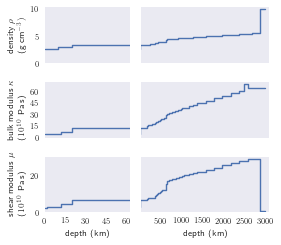

In [6]:
def read_model(field, model="models/earth.model.PREM"):
    columns = {'density': 2, 'kappa': 3, 'mu': 4}
    bottom, top, values = numpy.loadtxt(model, skiprows=1,
                                        usecols=(0,1,columns[field]),
                                        unpack=True)
    
    radius = top[-1]
    bottom, top, values = bottom[::-1], top[::-1], values[::-1]
    top = radius - top
    bottom = radius - bottom
    return bottom, top, values
    

def plot_column(column, values, x_label=None, y_label=None, 
                discontinuity=14, y_ticker=None):
    axis = axes[column, 0]
    axis.set_xlim((top[0], bottom[discontinuity]))
    
    leftlabel = 'on'
    bottomlabel = x_label is not None
    
    
    if x_label is not None:
        axis.set_xlabel(x_label)
        
    if y_label is not None:
        axis.set_ylabel(y_label)
    axis.tick_params(axis='both', which='both', 
                     top='off', right='off',
                     bottom=bottomlabel, left=leftlabel,
                     labelbottom=bottomlabel, labelleft=leftlabel)
    
    if y_ticker is not None:
        axis.yaxis.set_major_locator(y_ticker)
    axis.xaxis.set_major_locator(MultipleLocator(15))

    axis.step(top, values)
    axis.set_ylim(bottom=0.)

    axis = axes[column, 1]
    axis.set_xlim((top[discontinuity], bottom[-1]))

    if y_ticker is not None:
        axis.yaxis.set_major_locator(y_ticker)
    axis.xaxis.set_major_locator(MultipleLocator(500))
    
    if x_label is not None:
        axis.set_xlabel(x_label)
    axis.step(top, values)
    axis.set_ylim(bottom=0.)

    leftlabel = 'off'
    
    axis.tick_params(axis='both', which='both', 
                     top='off', right='off', left=leftlabel,
                     bottom=bottomlabel, labelbottom=bottomlabel,
                     labelleft=leftlabel)
    

with seaborn.axes_style("dark"):
    fig, axes = pyplot.subplots(3, 2, figsize=(4,3.5),
                                gridspec_kw = {'width_ratios': [2, 3]})
    bottom, top, density = read_model('density')
    width = bottom - top
    plot_column(0, density,
                y_label = (r'\begin{tabular}{l}'
                           r'density \(\rho\) \\'
                           r'(g cm\({}^{-3})\)'
                           r'\end{tabular}'))

    bottom, top, kappa = read_model('kappa')
    plot_column(1, kappa, y_ticker=MultipleLocator(15),
                y_label=(r'\begin{tabular}{l}'
                         r'bulk modulus \(\kappa\) \\'
                         r'(\(10^{10}\;\;\)Pa\(\,\)s)'
                         r'\end{tabular}'))

    bottom, top, mu = read_model('mu')
    plot_column(2, mu,
                y_label=(r'\begin{tabular}{l}'
                         r'shear modulus \(\mu\) \\'
                         r'(\(10^{10}\;\;\)Pa\(\,\)s)'
                         r'\end{tabular}'),
               x_label='depth (km)')

pyplot.tight_layout()
pyplot.savefig('figures/AGU-PREM.pdf', bbox_inches='tight')

## hydro geocenter motion

In [12]:
def geocenter_motion():
    args = {}
    GRGS = '../data/GRGS_files/'
    RL05 = '../data/RL05/extracted/'
    args['grid_folder'] = '../data/hydro/GRACE-ocean-grid/'
    args['batch'] = 25
    args['Voronoi'] = False
    args['network_size'] = 10
    args['method'] = 'summation'
    args['love_numbers_file'] = GRGS + 'Love_numbers.dat'
    args['from_year'] = 2004
    args['to_year'] = 2014
    #args['anomaly_folder']=GRGS
    #args['file_format'] = 'anomaly'
    args['anomaly_folder']=RL05
    args['file_format'] = 'RL05'
    args['debug'] = False
    args['geocenter_coefficients'] = GRGS + 'ocean-model-geocenter.txt'
    args = Record(**args)

    output = StringIO.StringIO()
    with redirect_stdout(output):
        hydro.geocenter(args)

    geocenter_timeseries = output.getvalue()
    output.close()

    fl = StringIO.StringIO(geocenter_timeseries)
    time, x, y, z, start, end = numpy.loadtxt(fl, unpack=True)
    fl.close()

    geo = numpy.array([x, y, z])

    delta_t = end - start

    t_ref, u_ref, v_ref = hydro.least_square_fit(time, geo, delta_t)

    x_ref = u_ref[:,NA] + (time-t_ref)[NA,:] * v_ref[:,NA]
    
    return time, x_ref, geo

time, x_ref, geo = geocenter_motion()

In [13]:
fig, axes = pyplot.subplots(3, 1, figsize=(4.75,4), sharex=True, sharey=True)

dates = numpy.array([hydro.decimal_year_to_date(t)
                     for t in time])
labels = [r'T_x', r'T_y', r'T_z']

for i in range(3):
    axes[i].plot(dates, x_ref[i] * 10, dates, geo[i] * 10)
    axes[i].yaxis.set_major_locator(MultipleLocator(1))
    axes[i].set_ylabel("\\({}\\) (mm)".format(labels[i]))
    seaborn.despine(ax=axes[i],
                   top=True, right=True, bottom=(i != 2))
    if i != 2:
        axes[i].tick_params(axis='x', 
                            which='both', 
                            bottom='off', 
                            labelbottom='off')
        
pyplot.savefig('figures/AGU-geocenter-motion.pdf', bbox_inches='tight',
              transparent=False)
pyplot.savefig('figures/talk-geocenter-motion.pdf', bbox_inches='tight',
              transparent=True)

## hydro velocity magnitude

### common

In [5]:
hydro_folder = '../data/hydro/RL05-logs/'

every = set(glob(join(hydro_folder, '*.log')))

voronoi = set(glob(join(hydro_folder, '*Voronoi.log')))


geometric = every - voronoi

station = {
    'summation': defaultdict(lambda : defaultdict(dict)),
    'transformation': defaultdict(lambda : defaultdict(dict))
}

for i in geometric:
    filename = strip_extension(basename(i))
    N = int(filename.split('-')[1])
    method = filename.split('-')[0]
    
    with codecs.open(i, 'rt', 'utf-8') as fl:
        for line in fl:
            stripped = line.replace("[", "").replace("]", "")
            words = stripped.split()
            try:
                key = words[0] + " " + words[1]
                station[method][N][key]['x'] = myfloat(words[3])
                station[method][N][key]['y'] = myfloat(words[4])
                station[method][N][key]['z'] = myfloat(words[5])
                
            except (IndexError, ValueError):
                pass    

def stats(method):
    data_set = station[method]
    
    key = numpy.array(sorted(data_set.keys()))
    mean = []
    std = []
    for N in key:
        d = data_set[N]
        std.append(d['v' + ' std']['x'])
        d = data_set[N]['v mean']
        x, y, z = d['x'], d['y'], d['z']
        mean.append(numpy.linalg.norm(numpy.array([x, y, z])))

    std = numpy.array(std)
    mean = numpy.array(mean)
    
    return key, mean, std

### for paper

In [11]:
fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2), sharey=True)

key, mean, std = stats('summation')
axes[0].plot(key, mean, 'red', alpha=0.5) # * numpy.sqrt(key))
axes[0].fill_between(key, mean-std, mean+std, alpha=0.25, facecolor='red',
                 edgecolor='none')

key, mean, std = stats('transformation')
axes[1].plot(key, mean, 'purple', alpha=0.5) # * numpy.sqrt(key))
axes[1].fill_between(key, mean-std, mean+std, alpha=0.25, facecolor='purple',
                 edgecolor='none')

for index, axis in enumerate(axes):
    axis.set_ylim(ymin=-0.35, ymax=1.05)
    seaborn.despine(ax=axis, 
                    top=True, right=True)
    if index == 1:
        axis.tick_params(axis='y', which='both', left='off', labelleft='off')
    axis.set_xlabel('network size \(N\)')
axes[0].set_ylabel(r'\(\Delta{\dot{T}}\) (mm/yr)')

pyplot.savefig('figures/AGU-hydro-velocity-paper.pdf', bbox_inches='tight')

### for poster

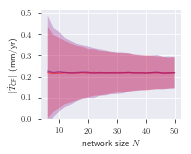

In [11]:
# the actual poster had
# hydro_folder = '../data/hydro/secular/'

fig, axis = pyplot.subplots(1, figsize=(2.5,2))

key, mean, std = stats('summation')
axis.plot(key, mean, 'red', alpha=0.5) # * numpy.sqrt(key))
axis.fill_between(key, mean-std, mean+std, alpha=0.25, facecolor='red',
                 edgecolor='none')

key, mean, std = stats('transformation')
axis.plot(key, mean, 'purple', alpha=0.5) # * numpy.sqrt(key))
axis.fill_between(key, mean-std, mean+std, alpha=0.25, facecolor='purple',
                 edgecolor='none')

axis.set_ylim(ymin=0)
seaborn.despine(ax=axis, 
                top=True, right=True,
                left=False, bottom=False)
axis.set_xlabel('network size \(N\)')
axis.set_ylabel(r'\(|\dot{T}_{\text{CF}}|\) (mm/yr)')

pyplot.savefig('figures/AGU-hydro-velocity.pdf', bbox_inches='tight')

## Example plots of timeseries

In [2]:
def timeseries_plot(neu_file, axis, label, plot_range=None, discontinuities=False):
    file_name = join('../data/sopac/raw', neu_file)
    data = numpy.loadtxt(file_name)
    if plot_range is None:
        time = data[:, 0]
        disp = data[:, axis] * 1000.
    else:
        epochs = numpy.logical_and(data[:, 0] >= plot_range[0], data[:, 0] <= plot_range[1])
        time = data[epochs, 0]
        disp = data[epochs, axis] * 1000.
        
    disc = (numpy.where(numpy.abs(numpy.diff(disp)) >= 100))[0]
    if discontinuities:
        disp[disc] = numpy.nan
    fig, axis = pyplot.subplots(1, figsize=(4.75,2))
    axis.xaxis.set_major_locator(MultipleLocator(2))
    plot_line, = axis.plot(time, disp, label=label)
    if discontinuities:
        for x in time[disc]:
            pyplot.axvline(x=x, color='red', linewidth=1)
    axis.legend(handles=[plot_line])
    axis.set_ylabel('displacement (mm)')



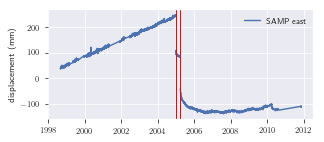

In [3]:
timeseries_plot('sampr.neu', 2, 'SAMP east', discontinuities=True)
pyplot.savefig('figures/thesis-SAMP-east.pdf', bbox_inches='tight')

In [4]:
timeseries_plot('brazr.neu', 3, 'BRAZ up', plot_range=(2000, 2017))
pyplot.savefig('figures/thesis-BRAZ-up.pdf', bbox_inches='tight')

## CM-CF-CN diagram

### poster

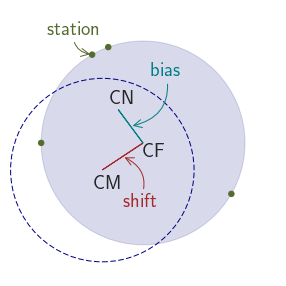

In [12]:
with seaborn.axes_style('white'):
    fig, axis = pyplot.subplots(1, 1, figsize=(5,5))
    axis.set_aspect('equal')
    CM = (0.35, 0.40)
    CF = (0.5, 0.5)
    r_plus = 0.375
    undeformed = pyplot.Circle(CM, 0.9 * r_plus, fill=False, 
                               linestyle='dashed', edgecolor='navy')
    deformed = pyplot.Circle(CF, r_plus, alpha=0.15,
                            facecolor='navy', edgecolor='navy')
    CM_CF = patches.FancyArrow(CM[0], CM[1], CF[0] - CM[0], CF[1] - CM[1], 
                                   length_includes_head=True,
                              facecolor='brown', edgecolor='brown')
    angles = [numpy.radians(x) for x in [330, 110, 120, 180]]
    stations = r_plus * numpy.array([numpy.cos(angles), numpy.sin(angles)])
    axis.add_patch(undeformed)
    axis.add_patch(deformed)
    axis.add_patch(CM_CF)
    seaborn.despine(fig=fig,ax=axis, left=True, bottom=True)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

    axis.text(CM[0] - 0.03, CM[1] - 0.07, 'CM', size=20)
    axis.text(CF[0], CF[1] - 0.05, 'CF', size=20)
    
    for i in range(len(angles)):
        p = stations[:, i]
        st = pyplot.Circle(CF + p, 0.01, facecolor='darkolivegreen', 
                           edgecolor='darkolivegreen')
        axis.add_patch(st)
        
    CN = CF + numpy.mean(stations, axis=1)
    
    CF_CN = patches.FancyArrow(CF[0], CF[1], CN[0] - CF[0], CN[1] - CF[1], 
                                   length_includes_head=True,
                              facecolor='teal', edgecolor='teal')
    axis.add_patch(CF_CN)
    axis.text(CN[0] - 0.03, CN[1] + 0.02, 'CN', size=20)
    
    axis.annotate("bias", xy=((CF[0] + CN[0]) / 2., (CF[1] + CN[1]) / 2.),
                  xytext=(20, 50), textcoords='offset points',
                  xycoords='axes fraction', size=20, color='teal',
                  weight='bold',
                 arrowprops={'arrowstyle': "->", 'edgecolor': 'teal',
                             'connectionstyle': "arc3,rad=-0.5"})
    axis.annotate("shift", xy=((CF[0] + CM[0]) / 2., (CF[1] + CM[1]) / 2.),
                  xytext=(-0, -50), textcoords='offset points',
                  xycoords='axes fraction', size=20, color='brown',
                  weight='bold',
                 arrowprops={'arrowstyle': "->", 'edgecolor': 'brown',
                             'connectionstyle': "arc3,rad=0.5"})
    
    example = CF + stations[:, 2]
    axis.annotate("station", xy=example,
                 xytext=(-45., 20.), textcoords='offset points',
                  xycoords='axes fraction', size=20, color='darkolivegreen',
                  weight='bold',
                 arrowprops={'arrowstyle': "->", 
                             'edgecolor': 'darkolivegreen',
                             'connectionstyle': "arc3,rad=0.5"})

    pyplot.savefig('figures/AGU-schematic.pdf', bbox_inches='tight')

### talk

In [13]:
with seaborn.axes_style('white'):
    fig, axis = pyplot.subplots(1, 1, figsize=(5,5))
    axis.set_aspect('equal')
    CM = (0.35, 0.40)
    CF = (0.5, 0.5)
    r_plus = 0.375
    undeformed = pyplot.Circle(CM, 0.9 * r_plus, fill=False, 
                               linestyle='dashed', edgecolor='navy')
    deformed = pyplot.Circle(CF, r_plus, alpha=0.15,
                            facecolor='navy', edgecolor='navy')
    CM_CF = patches.FancyArrow(CM[0], CM[1], CF[0] - CM[0], CF[1] - CM[1], 
                                   length_includes_head=True,
                              facecolor='brown', edgecolor='brown', head_width=0.015)
    angles = [numpy.radians(x) for x in [330, 110, 120, 180]]
    stations = r_plus * numpy.array([numpy.cos(angles), numpy.sin(angles)])
    axis.add_patch(undeformed)
    axis.add_patch(deformed)
    axis.add_patch(CM_CF)
    seaborn.despine(fig=fig,ax=axis, left=True, bottom=True)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

    axis.text(CM[0] - 0.03, CM[1] - 0.07, 'CM', size=20)
    axis.text(CF[0], CF[1] - 0.05, 'CF', size=20)
    
    for i in range(len(angles)):
        p = stations[:, i]
        st = pyplot.Circle(CF + p, 0.01, facecolor='darkolivegreen', 
                           edgecolor='darkolivegreen')
        axis.add_patch(st)
        
    CN = CF + numpy.mean(stations, axis=1)
    
    CF_CN = patches.FancyArrow(CF[0], CF[1], CN[0] - CF[0], CN[1] - CF[1], 
                                   length_includes_head=True,
                              facecolor='teal', edgecolor='teal', head_width=0.015)
    axis.add_patch(CF_CN)
    axis.text(CN[0] - 0.03, CN[1] + 0.02, 'CN', size=20)
    
    axis.annotate("network effect", xy=((CF[0] + CN[0]) / 2., (CF[1] + CN[1]) / 2.),
                  xytext=(20, 50), textcoords='offset points',
                  xycoords='axes fraction', size=20, color='teal',
                  weight='bold',
                 arrowprops={'arrowstyle': "->", 'edgecolor': 'teal',
                             'connectionstyle': "arc3,rad=-0.5"})
    axis.annotate("shift", xy=((CF[0] + CM[0]) / 2., (CF[1] + CM[1]) / 2.),
                  xytext=(-0, -50), textcoords='offset points',
                  xycoords='axes fraction', size=20, color='brown',
                  weight='bold',
                 arrowprops={'arrowstyle': "->", 'edgecolor': 'brown',
                             'connectionstyle': "arc3,rad=0.5"})
    
    example = CF + stations[:, 2]
    axis.annotate("station", xy=example,
                 xytext=(-45., 20.), textcoords='offset points',
                  xycoords='axes fraction', size=20, color='darkolivegreen',
                  weight='bold',
                 arrowprops={'arrowstyle': "->", 
                             'edgecolor': 'darkolivegreen',
                             'connectionstyle': "arc3,rad=0.5"})

    pyplot.savefig('figures/talk-schematic.pdf', bbox_inches='tight', transparent=True)

# displacement field

In [14]:
grid_file = '../data/Sumatra-Andaman/SOPAC/observed.log'

fig, axis = pyplot.subplots(figsize=(10,6))
plot_field(axis, read_field(grid_file), 
           horizontal=True, magnification=1e+6)

/home/zannat/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/zannat/anaconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()


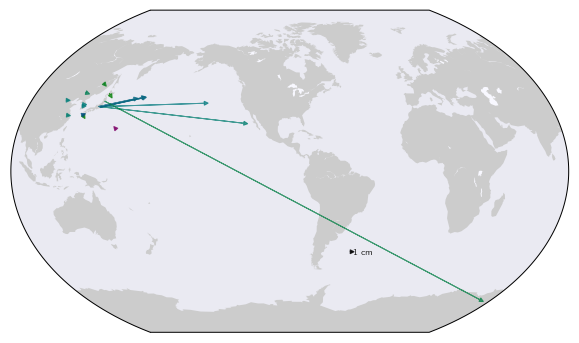

In [15]:
grid_file = '../data/Tohoku-Oki/SOPAC/observed.log'

fig, axis = pyplot.subplots(figsize=(10,6))
plot_field(axis, read_field(grid_file), 
           horizontal=True, magnification=1.e+5, lon_0=-90)

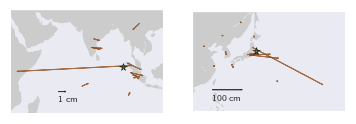

In [27]:
def SOPAC_GPS_figure(labels=True):
    fig, axis = pyplot.subplots(1, 2, figsize=(6,4))
    source_settings = {'markersize': 7.5,
                       'markeredgewidth': 0.5,
                       'markeredgecolor': 'black',
                       'markerfacecolor': 'darkolivegreen'}
    
    def panel(axis, grid_file,
              llcrnrlat, urcrnrlat, llcrnrlon, urcrnrlon,
              source,
              magnification, HEAD_LENGTH, HEAD_WIDTH,
              scale_lat, scale_lon, scale, legend_adjust):
        
        bm = Basemap(projection='merc', llcrnrlat=llcrnrlat,
                     urcrnrlat=urcrnrlat, llcrnrlon=llcrnrlon,
                     urcrnrlon=urcrnrlon, resolution='c', ax=axis)
        
        x, y = bm(numpy.degrees(source.longitude), 
                  90. - numpy.degrees(source.colatitude))
        axis.plot(x, y, '*', **source_settings)

        plot_field(axis, read_field(grid_file), 
                   horizontal=True, magnification=magnification, bm=bm,
                   HEAD_LENGTH=HEAD_LENGTH, HEAD_WIDTH=HEAD_WIDTH,
                   scale_lat=scale_lat, scale_lon=scale_lon,
                   scale=scale,
                   one_color='saddlebrown',
                   legend_adjust=legend_adjust)
        
        if labels:
            lats = [lat
                    for lat in range(llcrnrlat, urcrnrlat + 1)
                    if lat % 20 == 0]
            lons = [lon
                    for lon in range(llcrnrlon, urcrnrlon + 1)
                    if lon % 25 == 0]
            
            bm.drawmeridians(lons, labels=[True, False, True, False],
                             linewidth=0)
            bm.drawparallels(lats, labels=[True, False, True, False],
                             linewidth=0)
        
    panel(axis[0], '../data/Sumatra-Andaman/SOPAC/observed.log',
          -21, 31, 35, 115,
          Sumatra_Andaman(),
          4.5e+5, 1e+5, 5e+4,
          -10., 60., 1, 1.25)
    
    panel(axis[1], '../data/Tohoku-Oki/SOPAC/observed.log',
          9, 52, 110, 190,
          Tohoku_Oki(),
          1.75e+4, 7.5e+4, 3.75e+4,
          20., 120., 100, 35.)

SOPAC_GPS_figure()
pyplot.savefig('figures/AGU-SOPAC-GPS.pdf', bbox_inches='tight',
              transparent=False)
pyplot.clf()
SOPAC_GPS_figure(labels=False)
pyplot.savefig('figures/talk-SOPAC-GPS.pdf', bbox_inches='tight',
              transparent=True)

# ITRF sites

irrelevant set(['p805', 'p806', 'lia2', 'lia3', 'omh2', 'twtf', 'drej', 'herp', 'bhr1', 'bhr2', 'ufpr', 'mal2', 'dgav', 'bogi', 'str2', 'vard', 'helg', 'pbr2', 'tah1', 'tah2', 'wtzz', 'wtzs', 'wtzr', 'mobj', 'nrc2', 'tsk2', 'kokb', 'sag2', 'petp', 'tlse', 'osn2', 'hers', 'conz', 'con2', 'mobk', 'qmmt', 'godz', 'godn', 'gode', 'bdos', 'ade2', 'lck4', 'lck2', 'lck3', 'lhav', 'novj', 'brux', 'red2', 'glps', 'wett', 'mil2', 'kr0g', 'lhaz', 'hdf2', 'rio2', 'tnml', 'pre2', 'zim2', 'zimj', 'usn3', 'pur3', 'sfer', 'cn32', 'cagz', 'irkj', 'metz', 'joz2', 'yar1', 'yar2', 'yar3', 'mat1', 'nya1', 'kou1', 'tid1', 'tid2', 'thti', 'not1', 'ohi2', 'ohi3', 'tro1', 'graz', 'ohiz', 'hob2', 'yosh', 'bue2', 'unb1', 'uepp', 'qui2', 'reyz', 'brft', 'thu3', 'rcm6', 'darr', 'sutv', 'sutm', 'obe4', 'obe2', 'obe3', 'yakz', 'yaka', 'irkm', 'tixj', 'zwe2', 'hark', 'areg', 'mad2', 'areq', 'os0g', 'mr6g', 'hrm2', 'hart', 'mas1', 'stas'])


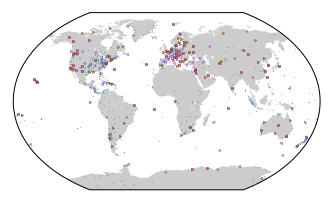

In [17]:
with seaborn.axes_style("ticks"):

    style= {'markerfacecolor': 'none', 
            'markeredgewidth': 0.5, 
            'markersize': 2.5,
            'alpha': 1}

    pyplot.figure(figsize=(5.5,4.5))
    bm = Basemap(projection='kav7', lon_0=0,
                 resolution='c')

    longitudes, latitudes = SOPAC_sites('../data/sopac/raw')
    x, y = bm(longitudes, latitudes)
    pyplot.plot(x, y, 'o', markeredgecolor='steelblue',
                markerfacecolor='steelblue',
                markeredgewidth=0.2,
                markersize=1, alpha=0.5)

    longitudes, latitudes = ITRF_sites('core_sites_itrf2008')
    x, y = bm(longitudes, latitudes)
    pyplot.plot(x, y, '<', markeredgecolor='mediumorchid', **style)
    
    longitudes, latitudes = ITRF_sites('core_sites_itrf2014')
    x, y = bm(longitudes, latitudes)
    pyplot.plot(x, y, '>', markeredgecolor='saddlebrown', **style)
    
    bm.fillcontinents(lake_color='#F8F8FF')
    seaborn.despine(bottom=True, left=True)

pyplot.savefig('figures/AGU-SOPAC.pdf', bbox_inches='tight',
              transparent=True)

# Source depth

## theoretical mean

In [18]:
# %%time
origin = defaultdict(list)
orientation = defaultdict(list)
for moment in moments:
    for depth in depths:
        options = summary.read_options(folder(moment, depth))
        for i in range(3):
            # in mm
            origin[moment, i].append(options['shift']['origin'][i] * 10)
            
            orientation[moment, i].append(options['shift']['EOP'][i])

In [19]:
for moment in moments:
    for i in range(3):
        if not numpy.allclose(numpy.array(origin[moment, i]), 0):
            print moment, ['x', 'y', 'z'][i], origin[moment, i][0]

iso z 0.268347439272
dc-1 x 1.85130517585
clvd-1 z 0.52151205967


In [20]:
for moment in moments:
    for i in range(3):
        if not numpy.allclose(numpy.array(orientation[moment, i]), 0):
            print moment, ['x', 'y', 'z'][i], orientation[moment, i][0]

dc-1 y 89.8031508254


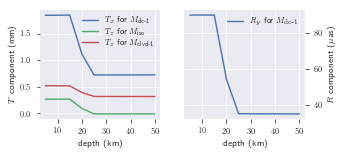

In [21]:
fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2))
axes[0].set_xlabel('depth (km)')
axes[0].set_ylabel(r'\(T\) component (mm)')
dc1x, = axes[0].plot(depths, origin['dc-1', 0], 
                     label=r'\(T_x\) for \(M_{\text{dc-1}}\)')
isoz, = axes[0].plot(depths, origin['iso', 2], 
                     label=r'\(T_z\) for \(M_{\text{iso}}\)')
clvd1z, = axes[0].plot(depths, origin['clvd-1', 2], 
                       label=r'\(T_z\) for \(M_{\text{clvd-1}}\)')
axes[0].legend(handles=[dc1x, isoz, clvd1z])
seaborn.despine(ax=axes[0])

axes[1].set_xlabel('depth (km)')
axes[1].yaxis.tick_right()
ylabel = axes[1].yaxis.label
ylabel.set_text(r'\(R\) component (\(\mu\)as)')
axes[1].yaxis.set_label_position("right")
dc1y, = axes[1].plot(depths, orientation['dc-1', 1], 
                     label=(r'\(R_y\) for '
                            r'\(M_{\mathrm{dc}\mbox{-}\mathrm{1}}\)'))
axes[1].legend(handles=[dc1y])
seaborn.despine(ax=axes[1], 
                top=True, right=False,
                left=True, bottom=False)

pyplot.savefig('figures/AGU-theoretical.pdf', bbox_inches='tight')

### agreement of theory and data

In [22]:
def check_agreement():
    for moment in moments:
        for depth in depths:
            options = summary.read_options(folder(moment, depth))
            field = summary.read_data(folder(moment, depth))
            theory = numpy.array(options['shift']['origin']) * 10
            practice = field.u_mean(options) * 10
            diff = norm(theory - practice)
            if not numpy.allclose(theory, practice):
                print moment, depth, 'origin'
                print theory, practice
                print diff, "{:.2f}".format((diff / norm(theory)) * 100)
            theory = numpy.array(options['shift']['EOP'])
            practice = field.w_mean(options)
            diff = norm(theory - practice) 
            if not numpy.allclose(theory, practice):
                print moment, depth, 'orientation'
                print theory, practice
                print diff, "{:.2f}".format((diff / norm(theory)) * 100)
            print
            
check_agreement()

iso 5 origin
[ 0.     0.     0.268] [ -5.034e-17  -7.161e-18   2.802e-01]
0.0118660214607 4.42

iso 10 origin
[ 0.     0.     0.269] [ -1.314e-17   2.811e-18   3.638e-01]
0.0951527819989 35.41

iso 15 origin
[ 0.     0.     0.269] [ -2.383e-17  -9.339e-18   3.491e-01]
0.0800656842046 29.76

iso 20 origin
[ 0.     0.     0.095] [ -1.059e-17   8.880e-18   1.179e-01]
0.0230443711103 24.29

iso 25 origin
[ 0.     0.    -0.009] [ -1.142e-17   5.367e-18  -1.560e-03]
0.0079229517358 83.55

iso 30 origin
[ 0.     0.    -0.009] [ -1.046e-17  -1.366e-18  -4.332e-03]
0.00498396912731 53.50

iso 35 origin
[ 0.     0.    -0.009] [ -1.049e-17  -1.060e-17  -5.728e-03]
0.00342126918685 37.39

iso 40 origin
[ 0.     0.    -0.009] [ -1.175e-17   6.579e-19  -6.482e-03]
0.00249958612127 27.83

iso 45 origin
[ 0.     0.    -0.009] [ -1.666e-17  -2.784e-19  -6.908e-03]
0.00190658567674 21.63

iso 50 origin
[ 0.     0.    -0.009] [ -1.469e-17  -1.843e-18  -7.146e-03]
0.00150050828587 17.35

dc-1 5 origin
[ 1

## bias estimates

CPU times: user 37.9 s, sys: 7.15 s, total: 45.1 s
Wall time: 49.6 s


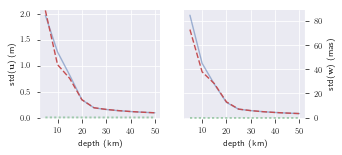

In [23]:
%%time
fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2))
axes[0].set_xlabel('depth (km)')
axes[0].set_ylabel(r'std(\(\mathbf{u}\)) (m)')

theory, practice, error = with_depth('origin', 'dc-1', scale=0.01)
magT = theoretical_bias('origin', 'dc-1', scale=0.01)

axes[0].plot(depths, norm(array([error[i] for i in range(3)]), axis=0),
             alpha=0.5)
axes[0].plot(depths, theory[0], ':', alpha=0.5, linewidth=2)
axes[0].set_ylim(bottom=-0.025)

axes[0].plot(depths, magT, '--')
seaborn.despine(ax=axes[0])

axes[1].set_xlabel('depth (km)')
axes[1].yaxis.tick_right()
ylabel = axes[1].yaxis.label
axes[1].yaxis.set_label_position('right')
ylabel.set_text(r'std(\(\mathbf{w}\)) (mas)')

theory, practice, error = with_depth('EOP', 'dc-1', scale=0.001)
magR = theoretical_bias('orientation', 'dc-1', scale=0.001)

axes[1].plot(depths, norm(array([error[i] for i in range(3)]), axis=0),
             alpha=0.5)
axes[1].plot(depths, theory[0], ':', alpha=0.5, linewidth=2)

axes[1].plot(depths, magR, '--')
axes[1].set_ylim(bottom=-1.)

seaborn.despine(ax=axes[1], 
                top=True, right=False, left=True, bottom=False)

pyplot.savefig('figures/AGU-std.pdf', bbox_inches='tight')

# Sampling bias

## hydro first test

In [24]:
subject = '../data/hydro/first-test-CLT-scaling/'

In [25]:
field = summary.binary_to_field(subject)

In [26]:
options = summary.read_options(subject)

In [27]:
field.u_mean(options), field.u_std(options)

(array([  9.023e-06,   1.699e-06,   6.000e-05]),
 array([ 0.12 ,  0.133,  0.136]))

In [28]:
field.w_mean(options), field.w_std(options)

(array([  9.827e-04,   6.576e-04,  -1.968e-07]),
 array([ 13.358,  11.971,   9.674]))

In [29]:
u = field.u_distributions(options, bin_count=5000)
w = field.w_distributions(options, bin_count=5000)
print 'u mean', numpy.array([u[i].mean for i in range(3)])
print ' u std', numpy.array([u[i].std for i in range(3)])
print 'w mean', numpy.array([w[i].mean for i in range(3)])
print ' w std', numpy.array([w[i].std for i in range(3)])

u mean [  9.214e-06   2.090e-06   5.999e-05]
 u std [ 0.12   0.133  0.136]
w mean [  1.007e-03   6.504e-04  -5.138e-06]
 w std [ 13.358  11.971   9.674]


In [30]:
%%time
N_max = 50
Ns = numpy.arange(N_max) + 1
u_samplings = [list(islice(u[i].samplings(), N_max)) for i in range(3)]
w_samplings = [list(islice(w[i].samplings(), N_max)) for i in range(3)]

CPU times: user 1min 45s, sys: 596 ms, total: 1min 45s
Wall time: 1min 45s


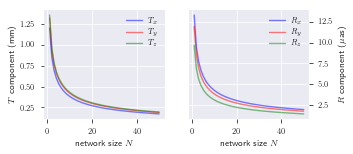

In [31]:
fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2))

axes[0].set_xlabel(r'network size \(N\)')
axes[0].set_ylabel(r'\(T\) component (mm)')

axes[1].set_xlabel(r'network size \(N\)')
axes[1].yaxis.tick_right()
ylabel = axes[1].yaxis.label
ylabel.set_text(r'\(R\) component (\(\mu\)as)')

labels = []

for i, color in [(0, 'b'), (1, 'r'), (2, 'g')]:
    data_set = u_samplings[i]
    stds = numpy.array([data_set[j - 1].std * 10 for j in Ns[:]])
    label, = axes[0].plot(Ns[:], stds, color, alpha=0.5,
                          label='\(T_{}\)'.format(['x', 'y', 'z'][i]))
    labels.append(label)

axes[0].legend(handles=labels)
seaborn.despine(ax=axes[0])

labels = []

for i, color in [(0, 'b'), (1, 'r'), (2, 'g')]:
    data_set = w_samplings[i]
    stds = numpy.array([data_set[j - 1].std for j in Ns[:]])
    label, = axes[1].plot(Ns[:], stds, color, alpha=0.5,
                          label='\(R_{}\)'.format(['x', 'y', 'z'][i]))
    labels.append(label)
    
axes[1].yaxis.set_label_position('right')
axes[1].legend(handles=labels)
seaborn.despine(ax=axes[1], 
                top=True, right=False, left=True, bottom=False)

pyplot.savefig('figures/AGU-bias-N-hydro.pdf', bbox_inches='tight')

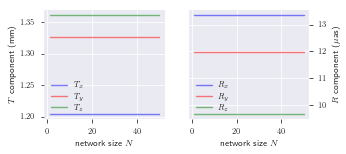

In [32]:
fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2))

axes[0].set_xlabel(r'network size \(N\)')
axes[0].set_ylabel(r'\(T\) component (mm)')

labels = []

for i, color in [(0, 'b'), (1, 'r'), (2, 'g')]:
    data_set = u_samplings[i]
    stds = numpy.array([data_set[j - 1].std * 10. for j in Ns[:]])
    label,=axes[0].plot(Ns[:], stds * numpy.sqrt(Ns), color, alpha=0.5,
                          label='\(T_{}\)'.format(['x', 'y', 'z'][i]))
    labels.append(label)
    
axes[0].legend(handles=labels, loc=3)
seaborn.despine(ax=axes[0])
labels = []

axes[1].set_xlabel(r'network size \(N\)')
axes[1].yaxis.tick_right()
axes[1].yaxis.set_label_position('right')
ylabel = axes[1].yaxis.label
ylabel.set_text(r'\(R\) component (\(\mu\)as)')

for i, color in [(0, 'b'), (1, 'r'), (2, 'g')]:
    data_set = w_samplings[i]
    stds = numpy.array([data_set[j - 1].std for j in Ns[:]])
    label,=axes[1].plot(Ns[:], stds * numpy.sqrt(Ns), color, alpha=0.5,
                          label='\(R_{}\)'.format(['x', 'y', 'z'][i]))
    labels.append(label)
    
axes[1].legend(handles=labels, loc=3)


seaborn.despine(ax=axes[1], 
                top=True, right=False, left=True, bottom=False)

pyplot.savefig('figures/AGU-bias-sqrt-N-hydro.pdf', bbox_inches='tight')

## dc-1 coseismic

In [5]:
#subject = folder('dc-1', 10)
subject = '../data/monte-carlo/raw-data/dc-1/10/'
field = summary.binary_to_field(subject)
options = summary.read_options(subject)
print options['shift']

N_max = 50
Ns = numpy.arange(N_max) + 1

{u'origin': [0.18538087685491159, 0.0, 0.0], u'EOP': [0.0, 89.82332912948826, 0.0], u'scale': 0.0}


In [6]:
def theoretical_stds():
    import pickle
    with open(subject + "/love.pickle") as fl:
        spheroidal, toroidal = pickle.load(fl)[0]
    
    T_CF = array(options['shift']['origin'])
    R_CF = array(options['shift']['EOP'])
    T = summary.standard_deviation_T(spheroidal, toroidal, 
                                     T_CF, options['model']['radius'])
    R = summary.standard_deviation_R(spheroidal, toroidal, R_CF)
    return T, R

theo_T, theo_R = theoretical_stds()

In [35]:
field.u_mean(options), field.u_std(options)

(array([  2.024e-01,  -1.177e-17,  -4.072e-18]),
 array([ 82.583,  42.151,  86.604]))

In [36]:
field.w_mean(options), field.w_std(options)

(array([  4.529e-15,   9.806e+01,  -2.554e-19]),
 array([  2.044e+04,   4.006e+04,   6.824e+00]))

In [37]:
u = field.u_distributions(options, bin_count=5000)
w = field.w_distributions(options, bin_count=5000)
print 'u mean', numpy.array([u[i].mean for i in range(3)])
print ' u std', numpy.array([u[i].std for i in range(3)])
print 'w mean', numpy.array([w[i].mean for i in range(3)])
print ' w std', numpy.array([w[i].std for i in range(3)])

u mean [ -5.810e+00  -3.339e-14  -3.331e-14]
 u std [ 82.598  42.975  88.586]
w mean [ -2.590e-12  -2.838e+03   9.086e-13]
 w std [  2.084e+04   4.006e+04   6.905e+00]


In [38]:
%%time

u_samplings = [list(islice(u[i].samplings(), N_max)) for i in range(3)]
w_samplings = [list(islice(w[i].samplings(), N_max)) for i in range(3)]

CPU times: user 2min 49s, sys: 544 ms, total: 2min 50s
Wall time: 2min 50s


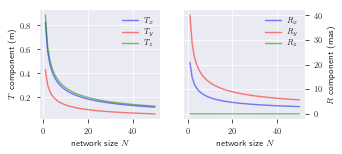

In [39]:
fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2))

axes[0].set_xlabel(r'network size \(N\)')
axes[0].set_ylabel(r'\(T\) component (m)')

axes[1].set_xlabel(r'network size \(N\)')
axes[1].yaxis.tick_right()
ylabel = axes[1].yaxis.label
ylabel.set_text(r'\(R\) component (mas)')

labels = []

for i, color in [(0, 'b'), (1, 'r'), (2, 'g')]:
    data_set = u_samplings[i]
    stds = numpy.array([data_set[j - 1].std * 0.01 for j in Ns[:]])
    label, = axes[0].plot(Ns[:], stds, color, alpha=0.5,
                          label='\(T_{}\)'.format(['x', 'y', 'z'][i]))
    labels.append(label)

axes[0].legend(handles=labels)
seaborn.despine(ax=axes[0])

labels = []

for i, color in [(0, 'b'), (1, 'r'), (2, 'g')]:
    data_set = w_samplings[i]
    stds = numpy.array([data_set[j - 1].std * 0.001 for j in Ns[:]])
    label, = axes[1].plot(Ns[:], stds, color, alpha=0.5,
                          label='\(R_{}\)'.format(['x', 'y', 'z'][i]))
    labels.append(label)
    
axes[1].legend(handles=labels)
axes[1].yaxis.set_label_position('right')

seaborn.despine(ax=axes[1], 
                top=True, right=False, left=True, bottom=False)

pyplot.savefig('figures/AGU-bias-N-components.pdf', bbox_inches='tight')


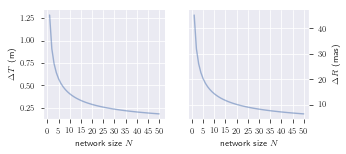

In [40]:
fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2))

axes[0].set_xlabel(r'network size \(N\)')
axes[0].set_ylabel(r'\(\Delta T\) (m)')
axes[0].xaxis.set_major_locator(MultipleLocator(5))

axes[1].set_xlabel(r'network size \(N\)')
axes[1].yaxis.tick_right()
axes[1].xaxis.set_major_locator(MultipleLocator(5))
ylabel = axes[1].yaxis.label
ylabel.set_text(r'\(\Delta R\) (mas)')

stds = array([magnitude(u_samplings, j - 1) * 0.01 for j in Ns[:]])
axes[0].plot(Ns[:], stds, alpha=0.5)
    
seaborn.despine(ax=axes[0])

stds = array([magnitude(w_samplings, j - 1) * 0.001 for j in Ns[:]])
axes[1].plot(Ns[:], stds, alpha=0.5)
axes[1].yaxis.set_label_position('right')

seaborn.despine(ax=axes[1], 
                top=True, right=False, left=True, bottom=False)

pyplot.savefig('figures/AGU-bias-N.pdf', bbox_inches='tight')
pyplot.savefig('figures/talk-bias-N.pdf', bbox_inches='tight',
              transparent=True)


translation 2.56747464556 +- 10.6450878685
rotation 4.63027107456 +- 10.6518868228


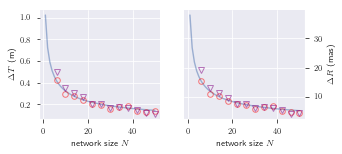

In [7]:
#subject = '../data/monte-carlo/dc-1--10/'
subject = '../data/monte-carlo/newer/'

#geometric = 'uniform-angle'
geometric = ''

#network_sizes = numpy.arange(5, 50 + 1, 5)
network_sizes = numpy.arange(6, 50 + 1, 4)

fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2))

axes[0].set_xlabel(r'network size \(N\)')
axes[0].set_ylabel(r'\(\Delta T\) (m)')

axes[1].set_xlabel(r'network size \(N\)')
axes[1].yaxis.tick_right()
ylabel = axes[1].yaxis.label
ylabel.set_text(r'\(\Delta R\) (mas)')
axes[1].yaxis.set_label_position('right')


def extract(subject, folder, task, N, component):
    filename = os.path.join(subject, folder, task + "-" + str(N) + ".log")
    with open(filename) as fl:
        for line in fl:
            words = line.split()
            if words[0] == component and words[1] == 'std':
                for word in words:
                    if word.startswith('(') and word.endswith(')'):
                        try:
                            return float(word[1:-1])
                        except ValueError:
                            pass
                
summation = numpy.array([extract(subject, geometric, 
                                 'summation', N, 'T') 
                         for N in network_sizes]) * 0.001
transformation = numpy.array([extract(subject, geometric,
                                      'transformation', N, 'T') 
                         for N in network_sizes]) * 0.001

ratio =  ((transformation - summation) / summation) * 100
print 'translation', ratio.mean(), '+-', ratio.std()

#summation2 = numpy.array([extract(subject, 'Voronoi', 
#                                 'summation', N, 'T') 
#                         for N in network_sizes]) * 0.001
#transformation2 = numpy.array([extract(subject, 'Voronoi',
#                                      'transformation', N, 'T') 
#                         for N in network_sizes]) * 0.001

#theo_T, theo_R = theoretical_stds()
#stds = numpy.array([magnitude(u_samplings, j - 1) for j in Ns[:]]) * 0.01
stds = theo_T * 0.01 / sqrt(Ns)
axes[0].plot(Ns[:], stds, alpha=0.5)
axes[0].plot(network_sizes, summation, 'o', markerfacecolor='none',
             markeredgewidth=1, markeredgecolor='red', alpha=0.5)
axes[0].plot(network_sizes, transformation, 'v', markerfacecolor='none', 
             markeredgewidth=1, markeredgecolor='purple', alpha=0.5)
#axes[0].plot(network_sizes, summation2, 'x', markerfacecolor='none',
#             markeredgewidth=1, markeredgecolor='red', alpha=0.5)
#axes[0].plot(network_sizes, transformation2, '+', markerfacecolor='none', 
#             markeredgewidth=1, markeredgecolor='purple', alpha=0.5)
seaborn.despine(ax=axes[0])

summation = numpy.array([extract(subject, geometric, 
                                 'summation', N, 'R') 
                         for N in network_sizes]) * 0.001
transformation = numpy.array([extract(subject, geometric,
                                      'transformation', N, 'R') 
                         for N in network_sizes]) * 0.001

ratio =  ((transformation - summation) / summation) * 100
print 'rotation', ratio.mean(), '+-', ratio.std()

#summation2 = numpy.array([extract(subject, 'Voronoi', 
#                                  'summation', N, 'R') 
#                         for N in network_sizes]) * 0.001
#transformation2 = numpy.array([extract(subject, 'Voronoi',
#                                      'transformation', N, 'R') 
#                        for N in network_sizes]) * 0.001

#stds = numpy.array([magnitude(w_samplings, j - 1) for j in Ns[:]]) * 0.001
stds = theo_R * 0.001 / sqrt(Ns)
axes[1].plot(Ns[:], stds, alpha=0.5)
axes[1].plot(network_sizes, summation, 'o', markerfacecolor='none',
             markeredgewidth=1, markeredgecolor='red', alpha=0.5)
axes[1].plot(network_sizes, transformation, 'v', markerfacecolor='none', 
             markeredgewidth=1, markeredgecolor='purple', alpha=0.5)
#axes[1].plot(network_sizes, summation2, 'x', markerfacecolor='none',
#             markeredgewidth=1, markeredgecolor='red', alpha=0.5)
#axes[1].plot(network_sizes, transformation2, '+', markerfacecolor='none', 
#             markeredgewidth=1, markeredgecolor='purple', alpha=0.5)
    
seaborn.despine(ax=axes[1], 
                top=True, right=False, left=True, bottom=False)

pyplot.savefig('figures/AGU-summation-transformation.pdf', 
               bbox_inches='tight')

# excluded epicentral cap

In [2]:
subject = '../data/bigger/dc-1/10/'
original_field = summary.binary_to_field(subject)
options = summary.read_options(subject)
print options['shift']

{u'origin': [0.18535883009756288, 0.0, 0.0], u'EOP': [0.0, 89.81268617860457, 0.0]}


In [3]:
def excluded(original_field, exes, all_axis=False):
    Tx = []
    Terr = []
    
    def find_mean(field):
        if all_axis:
            return norm(field.u_mean(options))
        else:
            return field.u_mean(options)[0]
        
    def find_std(field):
        if all_axis:
            return norm(field.u_std(options))
        else:
            return field.u_std(options)[0]
        
    for ex in exes:
        field = original_field.select(lambda theta, phi, u:
                                      theta > numpy.radians(ex))
        
        # in mm
        Tx.append(find_mean(field) * 10)
        Terr.append(find_std(field) * 10)
    
    return numpy.array(Tx), numpy.array(Terr)

In [4]:
%%time
exes1 = numpy.arange(0, 1.5, 0.1)
Tx1, Terr1 = excluded(original_field, exes1, all_axis=True)

CPU times: user 11.1 s, sys: 6.81 s, total: 17.9 s
Wall time: 18.1 s


In [5]:
%%time
exes2 = numpy.arange(1., 5.0, 0.2)
Tx2, Terr2 = excluded(original_field, exes2, all_axis=True)

CPU times: user 14.4 s, sys: 8.72 s, total: 23.1 s
Wall time: 23.3 s


In [6]:
fig, axes = pyplot.subplots(2, 2, figsize=(4.75,4))
axes[0,0].plot(exes1, Tx1)
axes[0,0].set_ylabel(r'\(T_x\) (mm)')
axes[0,0].xaxis.set_major_locator(MultipleLocator(0.5))

axes[0, 0].tick_params(axis='both', which='both', 
                 top='off', right='off', bottom='off',
                 labelbottom='off')

axes[1, 0].xaxis.set_major_locator(MultipleLocator(0.5))
axes[1, 0].yaxis.set_major_locator(MultipleLocator(200))
axes[1, 0].fill_between(exes1, Tx1, Tx1 + Terr1, alpha=0.25)
axes[1, 0].set_ylabel(r'\({\Delta T}\) (mm)')
axes[1, 0].set_xlabel(r'\(\theta_\text{ex}\) (degrees)')
seaborn.despine(ax=axes[1,0])

axes[0, 1].plot(exes2, Tx2)
axes[0, 1].xaxis.set_major_locator(MultipleLocator(1.))

axes[0, 1].tick_params(axis='both', which='both', 
                 top='off', right='off', bottom='off',
                 labelbottom='off')

axes[1, 1].fill_between(exes2, Tx2, Tx2 + Terr2, alpha=0.25)
axes[1, 1].set_xlabel(r'\(\theta_\text{ex}\) (degrees)')
axes[1, 1].xaxis.set_major_locator(MultipleLocator(1.))
seaborn.despine(ax=axes[1, 1])

pyplot.tight_layout()
pyplot.savefig('figures/AGU-epicentral-cap.pdf', bbox_inches='tight')

### excluded angle poster

In [47]:
%%time
exes3 = numpy.arange(0, 2.5, 0.1)
Tx3, Terr3 = excluded(original_field, exes3, all_axis=True)

CPU times: user 20 s, sys: 4.83 s, total: 24.9 s
Wall time: 25 s


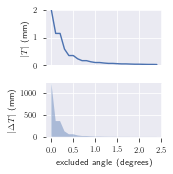

In [48]:
fig, axes = pyplot.subplots(2, 1, figsize=(2.5, 2.5), sharex=True)
axes[0].plot(exes3, Tx3)
axes[0].set_ylabel(r'\(|T|\) (mm)')
#axes[0].xaxis.set_major_locator(MultipleLocator(0.5))
#axes[0].set_xlabel(r'excluded angle (degrees)')

#axes[0].tick_params(axis='both', which='both', 
#                    top='off', right='off', bottom='off',
#                    labelbottom='off')
axes[0].set_ylim((0, 2.0))
seaborn.despine(ax=axes[0], bottom=True)
axes[0].tick_params(axis='x', which='both', bottom='off')

axes[1].xaxis.set_major_locator(MultipleLocator(0.5))
axes[1].yaxis.set_major_locator(MultipleLocator(500))
axes[1].fill_between(exes3, numpy.zeros_like(exes3), 
                     Terr3, alpha=0.4)
axes[1].set_ylabel(r'\(|\Delta T|\) (mm)')
axes[1].set_xlabel(r'excluded angle (degrees)')
axes[1].set_ylim((-25, 1250))
seaborn.despine(ax=axes[1])


pyplot.tight_layout()
pyplot.savefig('figures/AGU-epicentral-cap-poster.pdf', 
               bbox_inches='tight')

### excluded angle scaling

In [49]:
theta_0 = numpy.radians(2.)
subject = folder('dc-1', 10)
criteria = lambda theta, phi, u: theta > theta_0
field = summary.binary_to_field(subject).select(criteria)
options = summary.read_options(subject)
print options['shift']

{u'origin': [0.18535883009756288, 0.0, 0.0], u'EOP': [0.0, 89.81268617860457, 0.0]}


In [50]:
field.u_mean(options), field.u_std(options)

(array([  4.588e-03,  -2.043e-19,  -3.879e-20]),
 array([ 0.139,  0.075,  0.024]))

In [51]:
field.w_mean(options), field.w_std(options)

(array([  8.514e-17,   2.092e+00,  -4.800e-19]),
 array([ 36.577,  68.02 ,   0.304]))

In [52]:
u = field.u_distributions(options, bin_count=5000)
w = field.w_distributions(options, bin_count=5000)
print 'u mean', numpy.array([u[i].mean for i in range(3)])
print ' u std', numpy.array([u[i].std for i in range(3)])
print 'w mean', numpy.array([w[i].mean for i in range(3)])
print ' w std', numpy.array([w[i].std for i in range(3)])

u mean [  4.811e-03   2.385e-18  -2.168e-19]
 u std [ 0.139  0.075  0.024]
w mean [  1.443e-15   2.084e+00   5.690e-16]
 w std [ 36.585  68.02    0.304]


In [53]:
%%time
N_max = 50
Ns = numpy.arange(N_max) + 1
u_samplings = [list(islice(u[i].samplings(), N_max)) for i in range(3)]
w_samplings = [list(islice(w[i].samplings(), N_max)) for i in range(3)]

CPU times: user 1min 48s, sys: 464 ms, total: 1min 48s
Wall time: 2min 3s


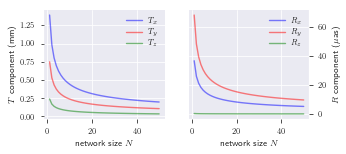

In [54]:
fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2))

axes[0].set_xlabel(r'network size \(N\)')
axes[0].set_ylabel(r'\(T\) component (mm)')

axes[1].set_xlabel(r'network size \(N\)')
axes[1].yaxis.tick_right()
ylabel = axes[1].yaxis.label
ylabel.set_text(r'\(R\) component (\(\mu\)as)')
axes[1].yaxis.set_label_position('right')

labels = []

for i, color in [(0, 'b'), (1, 'r'), (2, 'g')]:
    data_set = u_samplings[i]
    stds = numpy.array([data_set[j - 1].std * 10 for j in Ns[:]])
    label, = axes[0].plot(Ns[:], stds, color, alpha=0.5,
                          label='\(T_{}\)'.format(['x', 'y', 'z'][i]))
    labels.append(label)

axes[0].legend(handles=labels)
seaborn.despine(ax=axes[0])

labels = []

for i, color in [(0, 'b'), (1, 'r'), (2, 'g')]:
    data_set = w_samplings[i]
    stds = numpy.array([data_set[j - 1].std for j in Ns[:]])
    label, = axes[1].plot(Ns[:], stds, color, alpha=0.5,
                          label='\(R_{}\)'.format(['x', 'y', 'z'][i]))
    labels.append(label)
    
axes[1].legend(handles=labels)
seaborn.despine(ax=axes[1], 
                top=True, right=False, left=True, bottom=False)

pyplot.savefig('figures/AGU-bias-N-ex-2.pdf', bbox_inches='tight')

translation -0.710660476809 +- 5.94984424286
rotation 1.14320781649 +- 8.58111074791


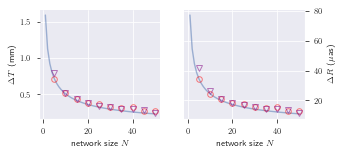

In [55]:
subject = '../data/monte-carlo/dc-1--10/'

network_sizes = numpy.arange(5, 50 + 1, 5)

fig, axes = pyplot.subplots(1, 2, figsize=(4.75,2))

axes[0].set_xlabel(r'network size \(N\)')
axes[0].set_ylabel(r'\(\Delta T\) (mm)')

axes[1].set_xlabel(r'network size \(N\)')
axes[1].yaxis.tick_right()
ylabel = axes[1].yaxis.label
ylabel.set_text(r'\(\Delta R\) (\(\mu\)as)')
axes[1].yaxis.set_label_position('right')

def magnitude(data_set, index):
    return norm(numpy.array([data_set[k][index].std
                                          for k in range(3)]))

def extract(subject, folder, task, N, component):
    filename = os.path.join(subject, folder, task + "-" + str(N) + ".log")
    with open(filename) as fl:
        for line in fl:
            words = line.split()
            if words[0] == component and words[1] == 'std':
                for word in words:
                    if word.startswith('(') and word.endswith(')'):
                        try:
                            return float(word[1:-1])
                        except ValueError:
                            pass
                
summation = numpy.array([extract(subject, 'excluded-2', 
                                 'summation', N, 'T') 
                         for N in network_sizes])
transformation = numpy.array([extract(subject, 'excluded-2',
                                      'transformation', N, 'T') 
                         for N in network_sizes])

ratio =  ((transformation - summation) / summation) * 100
print 'translation', ratio.mean(), '+-', ratio.std()

summation2 = numpy.array([extract(subject, 'excluded-2', 
                                 'summation', N, 'T') 
                         for N in network_sizes])
transformation2 = numpy.array([extract(subject, 'excluded-2',
                                      'transformation', N, 'T') 
                         for N in network_sizes])

stds = numpy.array([magnitude(u_samplings, j - 1) for j in Ns[:]]) * 10.
axes[0].plot(Ns[:], stds, alpha=0.5)
axes[0].plot(network_sizes, summation, 'o', markerfacecolor='none',
             markeredgewidth=1, markeredgecolor='red', alpha=0.5)
axes[0].plot(network_sizes, transformation, 'v', markerfacecolor='none', 
             markeredgewidth=1, markeredgecolor='purple', alpha=0.5)
#axes[0].plot(network_sizes, summation2, 'x', markerfacecolor='none',
#             markeredgewidth=1, markeredgecolor='red', alpha=0.5)
#axes[0].plot(network_sizes, transformation2, '+', markerfacecolor='none', 
#             markeredgewidth=1, markeredgecolor='purple', alpha=0.5)
seaborn.despine(ax=axes[0])

summation = numpy.array([extract(subject, 'excluded-2', 
                                 'summation', N, 'R') 
                         for N in network_sizes])
transformation = numpy.array([extract(subject, 'excluded-2',
                                      'transformation', N, 'R') 
                         for N in network_sizes])

ratio =  ((transformation - summation) / summation) * 100
print 'rotation', ratio.mean(), '+-', ratio.std()

summation2 = numpy.array([extract(subject, 'excluded-2', 
                                  'summation', N, 'R') 
                         for N in network_sizes])
transformation2 = numpy.array([extract(subject, 'excluded-2',
                                      'transformation', N, 'R') 
                         for N in network_sizes])

stds = numpy.array([magnitude(w_samplings, j - 1) for j in Ns[:]])
axes[1].plot(Ns[:], stds, alpha=0.5)
axes[1].plot(network_sizes, summation, 'o', markerfacecolor='none',
             markeredgewidth=1, markeredgecolor='red', alpha=0.5)
axes[1].plot(network_sizes, transformation, 'v', markerfacecolor='none', 
             markeredgewidth=1, markeredgecolor='purple', alpha=0.5)
#axes[1].plot(network_sizes, summation2, 'x', markerfacecolor='none',
#             markeredgewidth=1, markeredgecolor='red', alpha=0.5)
#axes[1].plot(network_sizes, transformation2, '+', markerfacecolor='none', 
#             markeredgewidth=1, markeredgecolor='purple', alpha=0.5)
    
seaborn.despine(ax=axes[1], 
                top=True, right=False, left=True, bottom=False)

pyplot.savefig('figures/AGU-summation-transformation-ex-2.pdf', 
               bbox_inches='tight')

# illustration of convolution

In [2]:
subject = '../data/degree-1/dc-1/10'
degree1 = summary.binary_to_field(subject)
options = summary.read_options(subject)
print options["shift"]

{u'origin': [0.18535883009756288, 0.0, 0.0], u'EOP': [0.0, 89.81268617860457, 0.0]}


In [3]:
u = degree1.u_distributions(options, bin_count=1000)
print 'mean', [u[i].mean for i in range(3)]
print 'std', [u[i].std for i in range(3)]

mean [0.18538137977845845, 0.0, 0.0]
std [0.18036546575534684, 0.071799817933830251, 0.17553673331873834]


CPU times: user 188 ms, sys: 12 ms, total: 200 ms
Wall time: 260 ms


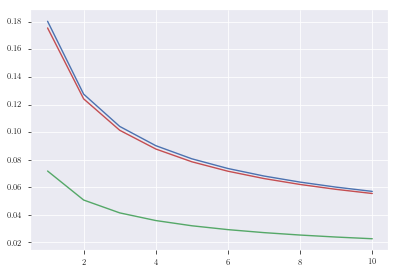

In [4]:
%%time
N_max = 10
Ns = numpy.arange(N_max) + 1
u_samplings = [list(islice(u[i].samplings(), N_max)) for i in range(3)]

for i in range(3):
    stds = numpy.array([u_samplings[i][j].std for j in range(N_max)])
    pyplot.plot(Ns, stds)

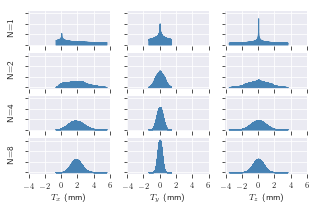

In [11]:
Ns = [1, 2, 4, 8]
fig, axes = pyplot.subplots(len(Ns), 3, figsize=(5,3), 
                            sharex=True, sharey=True)
for component in range(3):
    for sample in range(len(Ns)):
        sampling = u_samplings[component][Ns[sample] - 1].rescale(10)
        yaxis = axes[sample, component].yaxis
        xaxis = axes[sample, component].xaxis
        yaxis.set_major_locator(MultipleLocator(0.5))
        xaxis.set_major_locator(MultipleLocator(2.))
        yaxis.set_ticklabels([])
        sampling.plot(axes[sample, component])

for component in range(3):
    axes[-1, component].set_xlabel(r'\(T_{}\) (mm)'
                                   .format(['x', 'y', 'z'][component]))
    
for sample in range(len(Ns)):
    axes[sample, 0].set_ylabel('N={}'.format(Ns[sample]))
seaborn.despine()
pyplot.savefig('figures/AGU-degree-1-u.pdf', bbox_inches='tight')

In [60]:
w = degree1.w_distributions(options)
print 'mean', [w[i].mean for i in range(3)]
print 'std', [w[i].std for i in range(3)]

mean [1.4210854715202004e-14, 89.823284913088131, 1.4210854715202004e-14]
std [34.788286899728398, 87.706652241276885, 85.375842728360894]


CPU times: user 152 ms, sys: 0 ns, total: 152 ms
Wall time: 152 ms


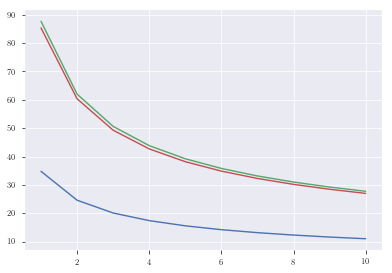

In [61]:
%%time
N_max = 10
Ns = numpy.arange(N_max) + 1
w_samplings = [list(islice(w[i].samplings(), N_max)) for i in range(3)]

for i in range(3):
    stds = numpy.array([w_samplings[i][j].std for j in range(N_max)])
    pyplot.plot(Ns, stds)

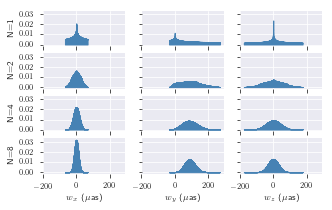

In [62]:
Ns = [1, 2, 4, 8]
fig, axes = pyplot.subplots(len(Ns), 3, figsize=(5,3), 
                            sharex=True, sharey=True)
for component in range(3):
    for sample in range(len(Ns)):
        sampling = w_samplings[component][Ns[sample] - 1].rescale(1)
        yaxis = axes[sample, component].yaxis
        yaxis.set_major_locator(MultipleLocator(0.01))
        sampling.plot(axes[sample, component])

for component in range(3):
    axes[-1, component].set_xlabel(r'\(w_{}\) (\(\mu\)as)'
                                   .format(['x', 'y', 'z'][component]))
    
for sample in range(len(Ns)):
    axes[sample, 0].set_ylabel('N={}'.format(Ns[sample]))
seaborn.despine()
pyplot.savefig('figures/AGU-degree-1-w.pdf', bbox_inches='tight')